# Car Price Prediction Multiple Linear Regression

Розділи:
    1) Нормалізація даних
    2) Аналіз і підготовка датасету
    3) Передбачення ціни
    4) Висновок

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Нормалізація даних:

In [10]:
car_data = pd.read_csv("CarPrice_Assignment.csv")

<AxesSubplot:>

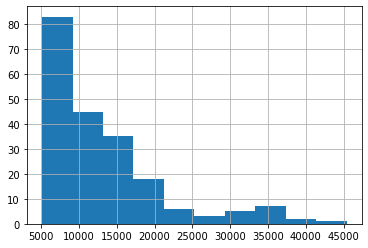

In [11]:
car_data['price'].hist()

Гістограма розподілу цін на автівки

Перевіримо ціни на нормальний розподіл:

In [12]:
from scipy.stats.mstats import normaltest
normaltest(car_data['price'])

NormaltestResult(statistic=77.37514013383584, pvalue=1.578344501676757e-17)

Надто низьке значення pvalue свідчить про поганий розподіл по ціні. 

Займемось нормалізацією:

(array([ 9., 11., 27., 35., 24., 22., 28., 26.,  8., 15.]),
 array([1.58469779, 1.58525393, 1.58581007, 1.58636621, 1.58692236,
        1.5874785 , 1.58803464, 1.58859078, 1.58914692, 1.58970306,
        1.5902592 ]),
 <BarContainer object of 10 artists>)

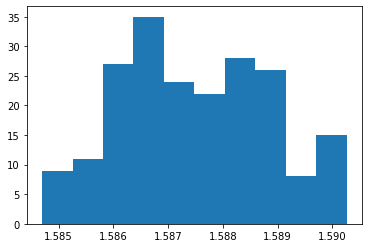

In [22]:
from scipy.stats import boxcox
bc_result = boxcox(car_data['price'])
boxcox_target = bc_result[0]
plt.hist(boxcox_target)

Гістаграма нового розподілу цін

In [23]:
normaltest(boxcox_target)

NormaltestResult(statistic=16.727142005583726, pvalue=0.00023321005129893173)

Ситуація значно покращилась!

# Аналіз і підготовка датасету

Всі змінні датасету:

In [27]:
car_data.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
car_company          object
dtype: object

Назва компанії, яка випускає авто і марка авто співпадають, тому зробимо наступне:

In [26]:
car_data['car_company'] = car_data['CarName'].str.split(' ',expand=True).iloc[:,[0]]

Список марок авто:

In [25]:
car_data['car_company'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

Замітимо, що тут є назви 'близнюки', виправимо це: 

In [28]:
car_data['car_company'] = car_data['car_company'].replace({'maxda': 'mazda', 'nissan': 'Nissan', 'porcshce': 'porsche', 'toyouta': 'toyota', 
                            'vokswagen': 'volkswagen', 'vw': 'volkswagen'})

##Found this code in this notebook : https://www.kaggle.com/hellbuoy/carprice-prediction-mlr-rfe-vif
car_data['car_company'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'Nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

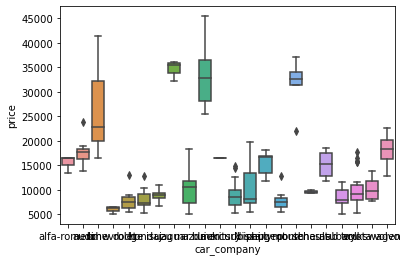

In [30]:
import seaborn as sns
sns.boxplot(x=car_data["car_company"], y=car_data["price"])
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

Зверху на графіку бачимо, що майже завжди компанія випускає авто в неперервному ціновому діапазоні - це важливо для правильної побудови моделі.

In [43]:
x = car_data['CarName'].str.split(' ',expand=True)
x

,0,1,2,3,4
0,alfa-romero,giulia,None,None,None
1,alfa-romero,stelvio,None,None,None
2,alfa-romero,Quadrifoglio,None,None,None
3,audi,100,ls,None,None
4,audi,100ls,None,None,None
...,...,...,...,...,...
200,volvo,145e,(sw),None,None
201,volvo,144ea,None,None,None
202,volvo,244dl,None,None,None
203,volvo,246,None,None,None


На таблиці зверху видно шум, виберемо сутт'єві параметри і помістимо вибірку з них в нову змінну(dummies):

In [44]:
categorical_features = ['car_company','fueltype','aspiration','doornumber','drivewheel','enginelocation','fuelsystem','enginetype','cylindernumber','carbody']
# Get the dummy variables for the categorical feature and store it in a new variable - 'dummies'

dummies = pd.get_dummies(car_data[categorical_features])

Поділимо машини на три класи(по вартості):


In [39]:
car_data['price'].describe()

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64

In [40]:
car_data.groupby(['car_company'])['price'].mean().sort_values()

car_company
chevrolet       6007.000000
dodge           7875.444444
plymouth        7963.428571
honda           8184.692308
subaru          8541.250000
isuzu           8916.500000
mitsubishi      9239.769231
renault         9595.000000
toyota          9885.812500
volkswagen     10077.500000
Nissan         10415.666667
mazda          10652.882353
saab           15223.333333
peugeot        15489.090909
alfa-romero    15498.333333
mercury        16503.000000
audi           17859.166714
volvo          18063.181818
bmw            26118.750000
porsche        31400.500000
buick          33647.000000
jaguar         34600.000000
Name: price, dtype: float64

In [41]:
car_data['price'] = car_data['price'].astype('int')
df_auto_temp = car_data.copy()
t = df_auto_temp.groupby(['car_company'])['price'].mean()
df_auto_temp = df_auto_temp.merge(t.reset_index(), how='left',on='car_company')
bins = [0,10000,20000,40000]
label =['Low Priced Car','Average Priced Car','High Priced Cars']
car_data['car_price_range'] = pd.cut(df_auto_temp['price_y'],bins,right=False,labels=label)

In [42]:
car_data.groupby(['car_company'])['car_price_range'].min()

car_company
Nissan         Average Priced Car
alfa-romero    Average Priced Car
audi           Average Priced Car
bmw              High Priced Cars
buick            High Priced Cars
chevrolet          Low Priced Car
dodge              Low Priced Car
honda              Low Priced Car
isuzu              Low Priced Car
jaguar           High Priced Cars
mazda          Average Priced Car
mercury        Average Priced Car
mitsubishi         Low Priced Car
peugeot        Average Priced Car
plymouth           Low Priced Car
porsche          High Priced Cars
renault            Low Priced Car
saab           Average Priced Car
subaru             Low Priced Car
toyota             Low Priced Car
volkswagen     Average Priced Car
volvo          Average Priced Car
Name: car_price_range, dtype: category
Categories (3, object): ['Low Priced Car' < 'Average Priced Car' < 'High Priced Cars']

In [48]:
categorical_features = ['car_price_range','fueltype','aspiration','doornumber','drivewheel','enginelocation',
                        'fuelsystem','enginetype','cylindernumber','carbody']

car_data[categorical_features].nunique()
dummies = pd.get_dummies(car_data[categorical_features])

In [49]:
numeric_cols = ["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio","stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"]
car_data[numeric_cols].describe()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220
std,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000
25%,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000
75%,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000
max,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000


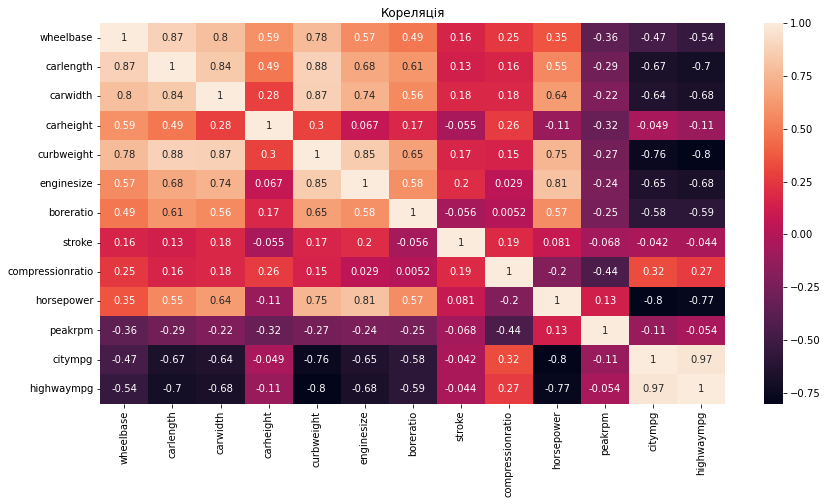

In [50]:
cor = car_data[numeric_cols].corr()
plt.figure(figsize=(14,7))
sns.heatmap(cor, annot=True);
plt.title('Кореляція');

Сітка кореляції дуже зручна для вибору параметрів, оскільки, якщо два параметри корелюють між собою - достатньо включити лише один з них. Видно, що citympg корелює з highwaympg, для прикладу лишимо citympg.

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(car_data[numeric_cols])
car_data[numeric_cols] = scaler.transform(car_data[numeric_cols])    

In [53]:
data_ohc = pd.concat([dummies,car_data[numeric_cols]],axis = 1)

In [54]:
data_ohc["target"] = boxcox_target

In [55]:
data_ohc = data_ohc.drop(columns = ["highwaympg"])

# Передбачення ціни

Тренуємо тестовий датасет:

In [56]:
from sklearn.model_selection import train_test_split

y_col = 'target'

feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [57]:
feature_cols

['car_price_range_Low Priced Car',
 'car_price_range_Average Priced Car',
 'car_price_range_High Priced Cars',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginelocation_rear',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',


Тренуємо регресійну модель:

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

error_df

[train    1.166103e-07
 test     2.498582e-07
 Name: one-hot enc, dtype: float64]

Отримані похибки для тренувального та тестового датасету мають одинаковий порядок, отже параметри для тренування моделі підібрані грамотно!

# Висновок

   Я навчився: перевіряти за допомогою утиліти normaltest з бібліотеки scipy.stats.mstats, чи потребує вибірка нормалізацію,
визначати важливі для моделі параметри, 'на око', а потім корегувати їх за допомогою сітки кореляцій, і найголовніше - це тренувати модель лінійної регресії на базі бібліотеки sklearn.